In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import sqlite3
import pickle

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Group19_Final Project/Online_Courses.csv')


# Drop any row with nulls in critical fields
required_cols = ['Title', 'Rating', 'Short Intro', 'Category', 'Skills', 'Number of viewers']
df = df.dropna(subset=required_cols)

# Filter to only English courses if 'language' column exists
if 'Language' in df.columns:
    df = df[df['Language'] == 'English']
df = df.dropna(subset=['Title', 'Rating'])

# Clean rating field
if 'Rating' in df.columns:
    df['Rating'] = df['Rating'].astype(str).str.extract(r'(\d+\.\d+)').astype(float)

# Clean viewers field
if 'Number of viewers' in df.columns:
    df['Number of viewers'] = df['Number of viewers'].astype(str).str.replace(',', '').str.strip()
    df['Number of viewers'] = pd.to_numeric(df['Number of viewers'], errors='coerce')

# Drop exact duplicate courses based on Title and Instructor (if available)
if 'Instructor' in df.columns:
    df = df.drop_duplicates(subset=['Title', 'Instructor'])
else:
    df = df.drop_duplicates(subset=['Title'])

# Fill NA for text features
df['Short Intro'] = df['Short Intro'].fillna('')
df['Category'] = df['Category'].fillna('')
df['Skills'] = df['Skills'].fillna('')
df['Sub-Category'] = df['Sub-Category'].fillna('')

In [ ]:
# --------- Clustering Part (with LLM Embeddings) ---------
from sentence_transformers import SentenceTransformer

# Applied SentenceTransformer Embedding
model = SentenceTransformer('all-MiniLM-L6-v2')

# Construct combined_text BEFORE encoding

df['combined_text'] = (
    df['Title'] + ' ' +
    df['Short Intro'] + ' ' +
    df['Sub-Category'] + ' ' +
    df['Skills']
)

# For clustering: use combined_text
llm_matrix = model.encode(df['combined_text'].tolist(), show_progress_bar=True)



Batches:   0%|          | 0/51 [00:00<?, ?it/s]

k=2, Silhouette Score=0.0488
k=3, Silhouette Score=0.0389
k=4, Silhouette Score=0.0337
k=5, Silhouette Score=0.0420
k=6, Silhouette Score=0.0435
k=7, Silhouette Score=0.0481
k=8, Silhouette Score=0.0502
k=9, Silhouette Score=0.0546
k=10, Silhouette Score=0.0571
k=11, Silhouette Score=0.0565
k=12, Silhouette Score=0.0543
k=13, Silhouette Score=0.0569
k=14, Silhouette Score=0.0571
k=15, Silhouette Score=0.0612
k=16, Silhouette Score=0.0590
k=17, Silhouette Score=0.0587
k=18, Silhouette Score=0.0549
k=19, Silhouette Score=0.0585
k=20, Silhouette Score=0.0599
k=21, Silhouette Score=0.0553
k=22, Silhouette Score=0.0548
k=23, Silhouette Score=0.0556
k=24, Silhouette Score=0.0552
k=25, Silhouette Score=0.0566
k=26, Silhouette Score=0.0595
k=27, Silhouette Score=0.0583
k=28, Silhouette Score=0.0568
k=29, Silhouette Score=0.0580
k=30, Silhouette Score=0.0622


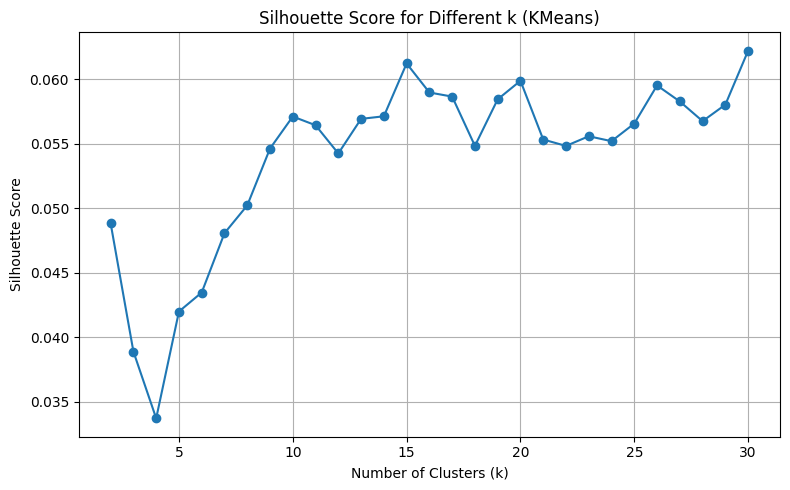


Best number of clusters based on silhouette score: 30


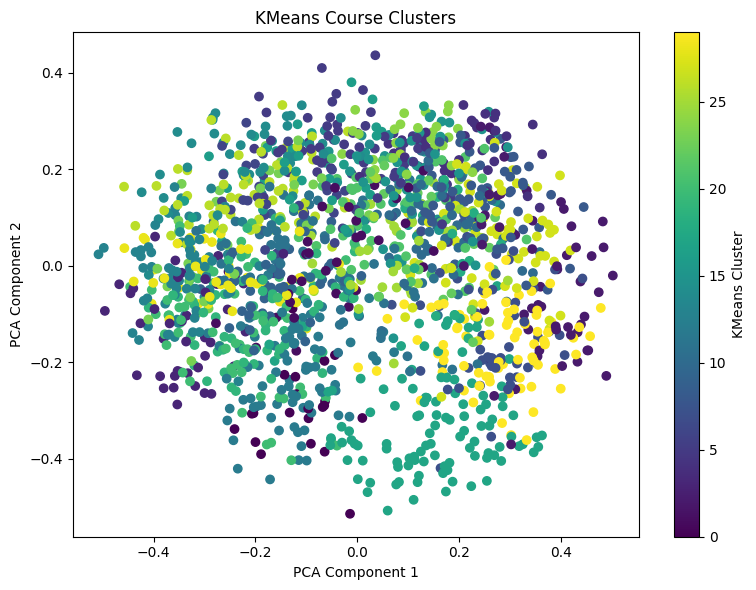

In [ ]:
# Evaluate silhouette scores for different cluster numbers (KMeans)
sil_scores = []
k_range = range(2, 31)
for k in k_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42)
    labels = kmeans_temp.fit_predict(llm_matrix)
    score = silhouette_score(llm_matrix, labels)
    sil_scores.append(score)
    print(f"k={k}, Silhouette Score={score:.4f}")

# Plot silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(k_range, sil_scores, marker='o')
plt.title("Silhouette Score for Different k (KMeans)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.tight_layout()
plt.show()

# Choose best k based on silhouette score
best_k = k_range[np.argmax(sil_scores)]  # automatically set to best silhouette score
print(f"\nBest number of clusters based on silhouette score: {best_k}")

# KMeans Clustering with best_k
kmeans = KMeans(n_clusters=best_k, random_state=42)
df['kmeans_cluster'] = kmeans.fit_predict(llm_matrix)


# PCA for visualization
pca = PCA(n_components=2)
X_2d = pca.fit_transform(llm_matrix)

# KMeans Visualization
plt.figure(figsize=(8, 6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=df['kmeans_cluster'], cmap='viridis')
plt.title("KMeans Course Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='KMeans Cluster')
plt.tight_layout()
plt.show()


In [ ]:
# --------- Content-Based Recommender System ---------
similarity_matrix = cosine_similarity(llm_matrix)

def recommend_courses(course_index, top_n=5):
    sim_scores = list(enumerate(similarity_matrix[course_index]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    recommended_indices = [i[0] for i in sim_scores]
    return df.iloc[recommended_indices][['Title', 'Category', 'Rating']].dropna(subset=['Rating'])

def get_similar_courses(query, embeddings_model, llm_matrix, df, top_n=5):
    query_vec = embeddings_model.encode([query.lower()])
    similarities = cosine_similarity(query_vec, llm_matrix).flatten()
    top_indices = similarities.argsort()[-top_n:][::-1]
    return df.iloc[top_indices][['Title', 'Category', 'Rating']].dropna(subset=['Rating'])

print("\n=== Recommended Courses (Content-Based) ===")
print("Input Course:", df.loc[10, 'Title'])
print(recommend_courses(10))

query = "machine learning"
print("\n=== Recommended Courses for Query: 'machine learning' ===")
print(get_similar_courses(query, model, llm_matrix, df))

# --------- Additional: Recommender Based on Viewers and Category ---------
df_numeric = df[['Number of viewers']].copy()
df_numeric['category_encoded'] = df['Category'].astype('category').cat.codes

scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(df_numeric.fillna(0))

def recommend_by_features(index, top_n=5):
    distances = np.linalg.norm(features_scaled - features_scaled[index], axis=1)
    nearest_indices = np.argsort(distances)[1:top_n+1]
    return df.iloc[nearest_indices][['Title', 'Category', 'Rating']].dropna(subset=['Rating'])

print("\n=== Recommended Courses (Viewers + Category) ===")
print("Input Course:", df.loc[10, 'Title'])
print(recommend_by_features(10))

# --------- Recommender Based on KMeans Cluster Membership ---------
def recommend_by_cluster(index, top_n=5):
    cluster_label = df.loc[index, 'kmeans_cluster']
    same_cluster = df[df['kmeans_cluster'] == cluster_label]
    top_courses = same_cluster.sort_values(by='Rating', ascending=False).dropna(subset=['Rating']).head(top_n)
    return top_courses[['Title', 'Category', 'Rating']]

print("\n=== Recommended Courses (Same KMeans Cluster) ===")
print("Input Course:", df.loc[10, 'Title'])
print(recommend_by_cluster(10))

# --------- Query-Based Recommender Functions ---------

def recommend_by_text_similarity(query, top_n=5):
    query_vec = model.encode([query])
    similarities = cosine_similarity(query_vec, llm_matrix).flatten()
    top_indices = similarities.argsort()[-top_n:][::-1]
    return df.iloc[top_indices][['Title', 'Category', 'Rating']]

def recommend_by_category(query, top_n=5):
    categories = df['Category'].dropna().unique()
    category_vecs = model.encode(categories)
    query_vec = model.encode([query])
    scores = cosine_similarity(query_vec, category_vecs).flatten()
    best_category = categories[np.argmax(scores)]
    filtered = df[df['Category'] == best_category]
    return filtered.sort_values(by='Rating', ascending=False).head(top_n)[['Title', 'Category', 'Rating']]

def recommend_by_cluster_query(query, top_n=5):
    query_vec = model.encode([query])
    closest_cluster = np.argmin(np.linalg.norm(kmeans.cluster_centers_ - query_vec, axis=1))
    same_cluster = df[df['kmeans_cluster'] == closest_cluster]
    return same_cluster.sort_values(by='Rating', ascending=False).head(top_n)[['Title', 'Category', 'Rating']]

# --------- Content-Based Recommender System ---------
similarity_matrix = cosine_similarity(llm_matrix)

def recommend_courses(course_index, top_n=5):
    sim_scores = list(enumerate(similarity_matrix[course_index]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    recommended_indices = [i[0] for i in sim_scores]
    return df.iloc[recommended_indices][['Title', 'Category', 'Rating']].dropna(subset=['Rating'])

def get_similar_courses(query, embeddings_model, llm_matrix, df, top_n=5):
    query_vec = embeddings_model.encode([query.lower()])
    similarities = cosine_similarity(query_vec, llm_matrix).flatten()
    top_indices = similarities.argsort()[-top_n:][::-1]
    return df.iloc[top_indices][['Title', 'Category', 'Rating']].dropna(subset=['Rating'])

print("\n=== Recommended Courses (Content-Based) ===")
print("Input Course:", df.loc[10, 'Title'])
print(recommend_courses(10))

query = "machine learning"
print("\n=== Recommended Courses for Query: 'machine learning' ===")
print(get_similar_courses(query, model, llm_matrix, df))

# --------- Additional: Recommender Based on Viewers and Category ---------
df_numeric = df[['Number of viewers']].copy()
df_numeric['category_encoded'] = df['Category'].astype('category').cat.codes

scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(df_numeric.fillna(0))

def recommend_by_features(index, top_n=5):
    distances = np.linalg.norm(features_scaled - features_scaled[index], axis=1)
    nearest_indices = np.argsort(distances)[1:top_n+1]
    return df.iloc[nearest_indices][['Title', 'Category', 'Rating']].dropna(subset=['Rating'])

print("\n=== Recommended Courses (Viewers + Category) ===")
print("Input Course:", df.loc[10, 'Title'])
print(recommend_by_features(10))

# --------- Recommender Based on KMeans Cluster Membership ---------
def recommend_by_cluster(index, top_n=5):
    cluster_label = df.loc[index, 'kmeans_cluster']
    same_cluster = df[df['kmeans_cluster'] == cluster_label]
    top_courses = same_cluster.sort_values(by='Rating', ascending=False).dropna(subset=['Rating']).head(top_n)
    return top_courses[['Title', 'Category', 'Rating']]

print("\n=== Recommended Courses (Same KMeans Cluster) ===")
print("Input Course:", df.loc[10, 'Title'])
print(recommend_by_cluster(10))

# --------- Query-Based Recommender Functions ---------

def recommend_by_text_similarity(query, top_n=5):
    query_vec = model.encode([query])
    similarities = cosine_similarity(query_vec, llm_matrix).flatten()
    top_indices = similarities.argsort()[-top_n:][::-1]
    return df.iloc[top_indices][['Title', 'Category', 'Rating']]

def recommend_by_category(query, top_n=5):
    categories = df['Category'].dropna().unique()
    category_vecs = model.encode(categories)
    query_vec = model.encode([query])
    scores = cosine_similarity(query_vec, category_vecs).flatten()
    best_category = categories[np.argmax(scores)]
    filtered = df[df['Category'] == best_category]
    return filtered.sort_values(by='Rating', ascending=False).head(top_n)[['Title', 'Category', 'Rating']]

def recommend_by_cluster_query(query, top_n=5):
    query_vec = model.encode([query])
    closest_cluster = np.argmin(np.linalg.norm(kmeans.cluster_centers_ - query_vec, axis=1))
    same_cluster = df[df['kmeans_cluster'] == closest_cluster]
    return same_cluster.sort_values(by='Rating', ascending=False).head(top_n)[['Title', 'Category', 'Rating']]




=== Recommended Courses (Content-Based) ===
Input Course: IT Fundamentals for Cybersecurity Specialization
                                                 Title          Category  \
805               Introduction to Software Engineering  Computer Science   
249      Software Development Lifecycle Specialization  Computer Science   
101  Java Programming and Software Engineering Fund...  Computer Science   
210            C Programming with Linux Specialization  Computer Science   
421  IBM DevOps and Software Engineering Profession...  Computer Science   

     Rating  
805     4.7  
249     4.6  
101     4.6  
210     4.7  
421     4.7  

=== Recommended Courses for Query: 'machine learning' ===
                                                  Title      Category  Rating
1204        Supervised Machine Learning: Classification  Data Science     4.8
860      Exploratory Data Analysis for Machine Learning  Data Science     4.6
649   Supervised Machine Learning: Regression and Cl...  D

In [ ]:
# Example query result
sample_queries = [
    "artificial intelligence",
    "financial accounting",
    "nutrition and wellness",
    "psychology and human behavior",
    "environmental science",
    "cybersecurity threats",
    "creative writing",
    "marketing strategy",
    "leadership and management",
    "robotics and automation"
]

query_examples = []

for query in sample_queries:
    rec_text_df = recommend_by_text_similarity(query)
    rec_text_df = rec_text_df.merge(df[['Title', 'Number of viewers']], on='Title', how='left')

    rec_cat_df = recommend_by_category(query)
    rec_cat_df = rec_cat_df.merge(df[['Title', 'Number of viewers']], on='Title', how='left')

    rec_cluster_df = recommend_by_cluster_query(query)
    rec_cluster_df = rec_cluster_df.merge(df[['Title', 'Number of viewers']], on='Title', how='left')

    rec_text = "; ".join([f"{t} (Rating: {r:.1f}, Viewers: {v:,.0f})" for t, r, v in rec_text_df[['Title', 'Rating', 'Number of viewers']].values])
    rec_cat = "; ".join([f"{t} (Rating: {r:.1f}, Viewers: {v:,.0f})" for t, r, v in rec_cat_df[['Title', 'Rating', 'Number of viewers']].values])
    rec_cluster = "; ".join([f"{t} (Rating: {r:.1f}, Viewers: {v:,.0f})" for t, r, v in rec_cluster_df[['Title', 'Rating', 'Number of viewers']].values])

    for i in range(min(5, len(rec_text_df))):
        query_examples.append({
            'Query': query,
            'Method': 'Text Similarity',
            'Title': rec_text_df.iloc[i]['Title'],
            'Category': rec_text_df.iloc[i]['Category'],
            'Rating': rec_text_df.iloc[i]['Rating'],
            'Viewers': rec_text_df.iloc[i]['Number of viewers']
        })

    for i in range(min(5, len(rec_cat_df))):
        query_examples.append({
            'Query': query,
            'Method': 'Category-Based',
            'Title': rec_cat_df.iloc[i]['Title'],
            'Category': rec_cat_df.iloc[i]['Category'],
            'Rating': rec_cat_df.iloc[i]['Rating'],
            'Viewers': rec_cat_df.iloc[i]['Number of viewers']
        })

    for i in range(min(5, len(rec_cluster_df))):
        query_examples.append({
            'Query': query,
            'Method': 'Cluster-Based',
            'Title': rec_cluster_df.iloc[i]['Title'],
            'Category': rec_cluster_df.iloc[i]['Category'],
            'Rating': rec_cluster_df.iloc[i]['Rating'],
            'Viewers': rec_cluster_df.iloc[i]['Number of viewers']
        })

highlighted_examples = []

for query in sample_queries:
    rec_df = recommend_by_text_similarity(query)
    rec_df = rec_df[['Title']].merge(df[['Title', 'Category', 'Rating', 'Number of viewers']], on='Title', how='left')

    top_rated = rec_df.sort_values(by='Rating', ascending=False).head(5)
    top_viewed = rec_df.sort_values(by='Number of viewers', ascending=False).head(5)
    top_combined = rec_df.copy()
    top_combined[['scaled_rating', 'scaled_views']] = MinMaxScaler().fit_transform(top_combined[['Rating', 'Number of viewers']])
    top_combined['composite_score'] = top_combined['scaled_rating'] * 0.7 + top_combined['scaled_views'] * 0.3
    top_combined = top_combined.sort_values(by='composite_score', ascending=False).head(5)

    for i in range(len(top_rated)):
        highlighted_examples.append({
            'Query': query,
            'Method': 'Top Rated',
            'Title': top_rated.iloc[i]['Title'],
            'Category': top_rated.iloc[i]['Category'],
            'Rating': top_rated.iloc[i]['Rating'],
            'Viewers': top_rated.iloc[i]['Number of viewers']
        })

    for i in range(len(top_viewed)):
        highlighted_examples.append({
            'Query': query,
            'Method': 'Top Viewed',
            'Title': top_viewed.iloc[i]['Title'],
            'Category': top_viewed.iloc[i]['Category'],
            'Rating': top_viewed.iloc[i]['Rating'],
            'Viewers': top_viewed.iloc[i]['Number of viewers']
        })

    for i in range(len(top_combined)):
        highlighted_examples.append({
            'Query': query,
            'Method': 'Top Combined Score',
            'Title': top_combined.iloc[i]['Title'],
            'Category': top_combined.iloc[i]['Category'],
            'Rating': top_combined.iloc[i]['Rating'],
            'Viewers': top_combined.iloc[i]['Number of viewers']
        })

highlighted_df = pd.DataFrame(highlighted_examples)
highlighted_df.to_csv("/content/drive/MyDrive/Group19_Final Project/query_highlighted_recommendations_final.csv", index=False)

query_df = pd.DataFrame(query_examples)
combined_df = pd.concat([query_df, highlighted_df], ignore_index=True)
combined_df.to_csv("/content/drive/MyDrive/Group19_Final Project/query_all_recommendations_final.csv", index=False)

# --------- Save to SQLite and Pickle ---------
pickle.dump(llm_matrix, open("llm_matrix.pkl", "wb"))



In [ ]:
def recommend_highlighted_courses(query, top_n=5):
    """
    Recommends highlighted courses based on a query, prioritizing top-rated,
    top-viewed, and a combined score.

    Args:
        query (str): The search query.
        top_n (int): The number of courses to recommend (default is 5).

    Returns:
        pd.DataFrame: A DataFrame containing the highlighted recommendations.
    """

    # Use the original DataFrame 'df' for text similarity calculation
    rec_df = recommend_by_text_similarity(query, df=df)  # Pass 'df' to the function

    rec_df = rec_df[['Title']].merge(df[['Title', 'Category', 'Rating', 'Number of viewers']], on='Title', how='left')

    # ... (rest of your function code remains the same) ...

    top_rated = rec_df.sort_values(by='Rating', ascending=False).head(top_n)
    top_viewed = rec_df.sort_values(by='Number of viewers', ascending=False).head(top_n)
    top_combined = rec_df.copy()
    top_combined[['scaled_rating', 'scaled_views']] = MinMaxScaler().fit_transform(top_combined[['Rating', 'Number of viewers']])
    top_combined['composite_score'] = top_combined['scaled_rating'] * 0.7 + top_combined['scaled_views'] * 0.3
    top_combined = top_combined.sort_values(by='composite_score', ascending=False).head(top_n)

    highlighted_recommendations = []

    for i in range(len(top_combined)):
        highlighted_recommendations.append({
            'Query': query,
            'Method': 'Top Combined Score',
            'Title': top_combined.iloc[i]['Title'],
            'Category': top_combined.iloc[i]['Category'],
            'Rating': top_combined.iloc[i]['Rating'],
            'Viewers': top_combined.iloc[i]['Number of viewers']
        })

    return pd.DataFrame(highlighted_recommendations)

def recommend_by_text_similarity(query, top_n=5, df=None): # add df argument
    """
    Recommends courses based on text similarity to the query.

    Args:
        query (str): The search query.
        top_n (int): The number of courses to recommend (default is 5).
        df (pd.DataFrame): DataFrame to use for selection. (default is None)
                            If None, the global df variable will be used.

    Returns:
        pd.DataFrame: A DataFrame containing the recommendations.
    """
    query_vec = model.encode([query])
    similarities = cosine_similarity(query_vec, llm_matrix).flatten()
    top_indices = similarities.argsort()[-top_n:][::-1]
    # Ensure we are using the correct DataFrame to pick recommendations
    if df is None:
        df = globals()['df']

    return df.iloc[top_indices][['Title', 'Category', 'Rating']]

In [ ]:
# prompt: test this recommend_highlighted_courses with some sample queries

# Example usage of recommend_highlighted_courses with sample queries
sample_queries = [
    "artificial intelligence",
    "financial accounting",
    "nutrition and wellness",
    "python programming",  # Added a new query
    "data science"  # Added another new query
]

for query in sample_queries:
    recommendations = recommend_highlighted_courses(query)
    print(f"\nHighlighted Recommendations for '{query}':")
    print(recommendations)




Highlighted Recommendations for 'artificial intelligence':
                     Query              Method  \
0  artificial intelligence  Top Combined Score   
1  artificial intelligence  Top Combined Score   
2  artificial intelligence  Top Combined Score   
3  artificial intelligence  Top Combined Score   
4  artificial intelligence  Top Combined Score   

                                               Title          Category  \
0       Introduction to Artificial Intelligence (AI)      Data Science   
1              Reinforcement Learning Specialization      Data Science   
2             Fundamentals of Reinforcement Learning      Data Science   
3  Artificial Intelligence: an Overview Specializ...  Computer Science   
4  AI Workflow: Machine Learning, Visual Recognit...      Data Science   

   Rating  Viewers  
0     4.7  10615.0  
1     4.8   2965.0  
2     4.8   2552.0  
3     4.7     40.0  
4     4.4     67.0  

Highlighted Recommendations for 'financial accounting':
           

In [ ]:

def recommend_highlighted_courses(query, top_n=5):
    """
    Recommends highlighted courses based on a query, prioritizing top-rated,
    top-viewed, and a combined score.

    Args:
        query (str): The search query.
        top_n (int): The number of courses to recommend (default is 5).

    Returns:
        pd.DataFrame: A DataFrame containing the highlighted recommendations.
    """

    rec_df = recommend_by_text_similarity(query)
    rec_df = rec_df[['Title']].merge(df[['Title', 'Category', 'Rating', 'Number of viewers']], on='Title', how='left')

    top_rated = rec_df.sort_values(by='Rating', ascending=False).head(top_n)
    top_viewed = rec_df.sort_values(by='Number of viewers', ascending=False).head(top_n)
    top_combined = rec_df.copy()
    top_combined[['scaled_rating', 'scaled_views']] = MinMaxScaler().fit_transform(top_combined[['Rating', 'Number of viewers']])
    top_combined['composite_score'] = top_combined['scaled_rating'] * 0.7 + top_combined['scaled_views'] * 0.3
    top_combined = top_combined.sort_values(by='composite_score', ascending=False).head(top_n)

    highlighted_recommendations = []

    for i in range(len(top_combined)):
        highlighted_recommendations.append({
            'Query': query,
            'Method': 'Top Combined Score',
            'Title': top_combined.iloc[i]['Title'],
            'Category': top_combined.iloc[i]['Category'],
            'Rating': top_combined.iloc[i]['Rating'],
            'Viewers': top_combined.iloc[i]['Number of viewers']
        })

    return pd.DataFrame(highlighted_recommendations)


In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np

# Load the query-based recommendation results
df = pd.read_csv("/content/drive/MyDrive/Group19_Final Project/query_all_recommendations_final.csv")

# Filter to only the core recommendation methods
df = df[df['Method'].isin(['Text Similarity', 'Category-Based', 'Cluster-Based'])]

# Load pre-trained embedding model (MiniLM)
model = SentenceTransformer('all-MiniLM-L6-v2')

# Compute cosine similarity between each query and the recommended course titles
results = []
for (query, method), group in df.groupby(['Query', 'Method']):
    query_vec = model.encode([query])  # Embed the query
    title_vecs = model.encode(group['Title'].astype(str).tolist())  # Embed all recommended titles
    avg_sim = cosine_similarity(query_vec, title_vecs).flatten().mean()  # Compute average cosine similarity
    results.append({
        'Query': query,
        'Method': method,
        'Avg Cosine Similarity': avg_sim
    })

# Save the evaluation results
df_cosine = pd.DataFrame(results)
df_cosine.to_csv("/content/drive/MyDrive/Group19_Final Project/cosine_similarity_results.csv", index=False)

print("✅ Average semantic cosine similarity has been computed and saved to cosine_similarity_results.csv")

✅ Average semantic cosine similarity has been computed and saved to cosine_similarity_results.csv


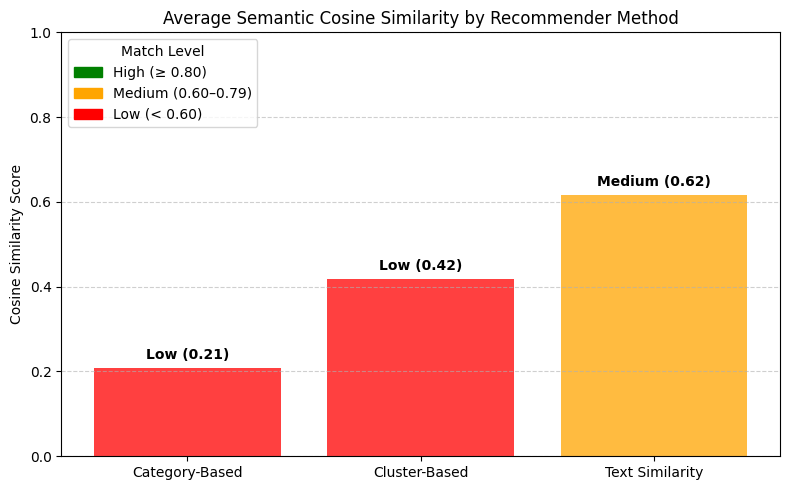

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Load the cosine similarity results
df_cosine = pd.read_csv("/content/drive/MyDrive/Group19_Final Project/cosine_similarity_results.csv")

# Group by method and calculate average similarity
df_avg = df_cosine.groupby("Method")["Avg Cosine Similarity"].mean().reset_index()

# Classify match level
def classify(score):
    if score >= 0.8:
        return "High"
    elif score >= 0.6:
        return "Medium"
    else:
        return "Low"

df_avg["Match Level"] = df_avg["Avg Cosine Similarity"].apply(classify)

# Assign colors
color_map = {"High": "green", "Medium": "orange", "Low": "red"}
colors = df_avg["Match Level"].map(color_map)

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(df_avg["Method"], df_avg["Avg Cosine Similarity"], color=colors, alpha=0.75)
plt.title("Average Semantic Cosine Similarity by Recommender Method")
plt.ylabel("Cosine Similarity Score")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Annotate each bar with score and level
for bar, score, level in zip(bars, df_avg["Avg Cosine Similarity"], df_avg["Match Level"]):
    plt.text(bar.get_x() + bar.get_width() / 2, score + 0.02, f"{level} ({score:.2f})",
             ha='center', fontsize=10, fontweight='bold')

# Legend
legend = [
    mpatches.Patch(color='green', label='High (≥ 0.80)'),
    mpatches.Patch(color='orange', label='Medium (0.60–0.79)'),
    mpatches.Patch(color='red', label='Low (< 0.60)')
]
plt.legend(handles=legend, title="Match Level", loc='upper left')

# Save the figure
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/Group19_Final Project/cosine_similarity_plot.png", dpi=300)
plt.show()